# Análisis de Clustering en Datos preprocesados con FFT
### Objetivo
Implementar análisis de clustering en el dominio de frecuencia para verificar si existe separación evidente entre las clases de daño (N1, N2, N3) usando pares sincronizados de señales (S2, S1).

### Contexto del Proyecto
#### Estado Actual
- Datos raw: 71 mediciones totales de 51 aisladores únicos
- Múltiples pasadas: algunos aisladores tienen 1-3 evaluaciones (pasada_01, pasada_02, pasada_03)
- Por defecto: cargamos solo **pasada_01** para evitar duplicados y colisiones de IDs entre edificios
- Etiquetas: nivel_damage.csv mapea (edificio, pasada, specimen_id) → {N1, N2, N3}

#### Concepto Clave
- **1 datapoint = 1 par (S2, S1)** de una medición sincronizada
- El daño se manifiesta en la **relación entre S2 y S1**, no en señales individuales
- S2 = excitación basal, S1 = respuesta estructural filtrada por el aislador
- **ID Global**: Para distinguir aisladores entre edificios, usamos `edificio_pasada_specimen_id`

In [30]:
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


# Configuración de plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['font.size'] = 12

print("📦 Librerías cargadas correctamente")

📦 Librerías cargadas correctamente


## 1. Carga de Pares de Señales (S2, S1)

Cargamos las señales sincronizadas de vibración como pares:
- **S2**: Sensor en sótano 2 (base del aislador) - Excitación
- **S1**: Sensor en sótano 1 (sobre el aislador) - Respuesta
- Estructura: `processed/synchronized/edificio_XX/pasada_YY/specimen_id/S1_synchronized.txt`

In [31]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
# Importar función de utilidades
sys.path.append('../utils/clustering')

# Importar logger de métricas
from metrics_logger import ClusteringMetricsLogger

# Inicializar logger
RESULTS_FILE = 'clustering_experiments.csv'
logger = ClusteringMetricsLogger(output_file=RESULTS_FILE)

print(f"📊 Logger inicializado: {RESULTS_FILE}")

📊 Logger inicializado: clustering_experiments.csv


In [33]:
from clustering_utils import load_paired_signals

# Configurar rutas
SIGNALS_DIR = '../../data/processed/synchronized/'
LABELS_CSV = '../../data/nivel_damage.csv'

print("🔧 Configuración:")
print(f"   📂 Directorio de señales: {SIGNALS_DIR}")
print(f"   📋 Archivo de etiquetas: {LABELS_CSV}")
print(f"   🎯 Pasada a cargar: pasada_01 (por defecto)")

🔧 Configuración:
   📂 Directorio de señales: ../../data/processed/synchronized/
   📋 Archivo de etiquetas: ../../data/nivel_damage.csv
   🎯 Pasada a cargar: pasada_01 (por defecto)


In [34]:
# Cargar pares de señales (S2, S1)
paired_data = load_paired_signals(
    signals_dir=SIGNALS_DIR,
    labels_csv=LABELS_CSV,
    pasada='pasada_01',        # Solo primera pasada (evita duplicados entre edificios)
    target_length=60000,       # Estandarizar a 60,000 muestras (10 min @ 100Hz)
    verbose=True               # Mostrar progreso detallado
)

print(f"\n✅ Pares cargados exitosamente: {len(paired_data)}")

📋 PASO 1: Cargando etiquetas...
   ✓ Cargadas etiquetas para 145 registros (edificio/pasada/specimen)

📂 PASO 2: Filtrado por pasada 'pasada_01'...
   ✓ 51 registros en pasada_01

🔄 PASO 3: Cargando pares (S2, S1)...
   ✓ A1: 59,999 muestras → 60,000 (padded) | N1 | Tipo B
   ✓ A2: 59,999 muestras → 60,000 (padded) | N1 | Tipo B
   ✓ A3: 59,999 muestras → 60,000 (padded) | N1 | Tipo C
   ✓ A4: 59,999 muestras → 60,000 (padded) | N1 | Tipo B
   ✓ A5: 59,999 muestras → 60,000 (padded) | N3 | Tipo A
   ✓ A6: 59,999 muestras → 60,000 (padded) | N3 | Tipo A
   ✓ A7: 59,999 muestras → 60,000 (padded) | N1 | Tipo C
   ✓ A8: 59,999 muestras → 60,000 (padded) | N2 | Tipo B
   ✓ A9: 59,999 muestras → 60,000 (padded) | N2 | Tipo C
   ✓ A10: 59,999 muestras → 60,000 (padded) | N2 | Tipo C
   ✓ A11: 59,999 muestras → 60,000 (padded) | N2 | Tipo C
   ✓ A12: 59,999 muestras → 60,000 (padded) | N1 | Tipo C
   ✓ A13: 59,999 muestras → 60,000 (padded) | N1 | Tipo C
   ✓ A14: 59,999 muestras → 60,000 (pa

### Inspección de los Datos Cargados

In [35]:
# Inspeccionar el primer par cargado
print("📋 ESTRUCTURA DE UN PAR (ejemplo con el primer espécimen):")
print("=" * 60)

first_pair = paired_data[0]

print(f"🆔 Specimen ID: {first_pair['specimen_id']}")
print(f"🔖 Specimen ID Global: {first_pair['specimen_id_global']}")
print(f"🏢 Edificio: {first_pair['edificio']}")
print(f"📍 Pasada: {first_pair['pasada']}")
print(f"🏷️  Nivel de daño: {first_pair['nivel_dano']}")
print(f"🔧 Tipo de aislador: {first_pair['tipo']}")
print(f"📏 Longitud original: {first_pair['original_length']:,} muestras")
print(f"\n📊 Señal S2 (Sótano 2 - Base):")
print(f"   Shape: {first_pair['signal_S2'].shape}")
print(f"   Ejes: [N-S, E-W, U-D]")
print(f"   Min: [{first_pair['signal_S2'][:, 0].min():.6f}, {first_pair['signal_S2'][:, 1].min():.6f}, {first_pair['signal_S2'][:, 2].min():.6f}]")
print(f"   Max: [{first_pair['signal_S2'][:, 0].max():.6f}, {first_pair['signal_S2'][:, 1].max():.6f}, {first_pair['signal_S2'][:, 2].max():.6f}]")

print(f"\n📊 Señal S1 (Sótano 1 - Superior):")
print(f"   Shape: {first_pair['signal_S1'].shape}")
print(f"   Ejes: [N-S, E-W, U-D]")
print(f"   Min: [{first_pair['signal_S1'][:, 0].min():.6f}, {first_pair['signal_S1'][:, 1].min():.6f}, {first_pair['signal_S1'][:, 2].min():.6f}]")
print(f"   Max: [{first_pair['signal_S1'][:, 0].max():.6f}, {first_pair['signal_S1'][:, 1].max():.6f}, {first_pair['signal_S1'][:, 2].max():.6f}]")

print("=" * 60)

📋 ESTRUCTURA DE UN PAR (ejemplo con el primer espécimen):
🆔 Specimen ID: A1
🔖 Specimen ID Global: edificio_01_pasada_01_A1
🏢 Edificio: edificio_01
📍 Pasada: pasada_01
🏷️  Nivel de daño: N1
🔧 Tipo de aislador: B
📏 Longitud original: 59,999 muestras

📊 Señal S2 (Sótano 2 - Base):
   Shape: (60000, 3)
   Ejes: [N-S, E-W, U-D]
   Min: [-0.886049, -0.963544, -0.200376]
   Max: [1.150439, 1.084325, 0.165302]

📊 Señal S1 (Sótano 1 - Superior):
   Shape: (60000, 3)
   Ejes: [N-S, E-W, U-D]
   Min: [-0.243628, -0.296160, -0.221557]
   Max: [0.212175, 0.280202, 0.236469]


In [36]:
# Crear DataFrame resumen de todos los pares cargados
summary_df = pd.DataFrame([
    {
        'Specimen_ID': pair['specimen_id'],
        'Specimen_ID_Global': pair['specimen_id_global'],
        'Edificio': pair['edificio'],
        'Pasada': pair['pasada'],
        'Nivel_Dano': pair['nivel_dano'],
        'Tipo': pair['tipo'],
        'Long_Original': pair['original_length'],
        'Long_Estandarizada': pair['signal_S2'].shape[0]
    }
    for pair in paired_data
])

print("\n📊 RESUMEN DE TODOS LOS PARES CARGADOS:")
print(summary_df.to_string(index=False))

print(f"\n✅ PASO 1 COMPLETADO")
print(f"   • {len(paired_data)} pares (S2, S1) cargados y estandarizados")
print(f"   • Distribución: {summary_df['Nivel_Dano'].value_counts().to_dict()}")
print(f"   • Todas las señales estandarizadas a 60,000 muestras")
print(f"   • Pasada cargada: {summary_df['Pasada'].unique()[0]}")


📊 RESUMEN DE TODOS LOS PARES CARGADOS:
Specimen_ID        Specimen_ID_Global    Edificio    Pasada Nivel_Dano     Tipo  Long_Original  Long_Estandarizada
         A1  edificio_01_pasada_01_A1 edificio_01 pasada_01         N1        B          59999               60000
         A2  edificio_01_pasada_01_A2 edificio_01 pasada_01         N1        B          59999               60000
         A3  edificio_01_pasada_01_A3 edificio_01 pasada_01         N1        C          59999               60000
         A4  edificio_01_pasada_01_A4 edificio_01 pasada_01         N1        B          59999               60000
         A5  edificio_01_pasada_01_A5 edificio_01 pasada_01         N3        A          59999               60000
         A6  edificio_01_pasada_01_A6 edificio_01 pasada_01         N3        A          59999               60000
         A7  edificio_01_pasada_01_A7 edificio_01 pasada_01         N1        C          59999               60000
         A8  edificio_01_pasada_01_A8 ed

## 2. Aplicación del FFT

Transformamos las señales del dominio temporal al dominio de frecuencia usando FFT.

In [37]:
# Importar función FFT de utilidades
from clustering_utils import apply_fft_to_pairs

# Aplicar FFT a todos los pares
fft_data = apply_fft_to_pairs(
    paired_data=paired_data,
    sampling_rate=100  # Hz (confirmado en archivos raw)
)

print(f"\n✅ FFT aplicado a {len(fft_data)} pares exitosamente")

🔄 PASO 2: Aplicando FFT a cada par (S2, S1)...
   ✓ A1: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A2: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A3: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A4: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A5: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A6: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A7: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A8: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
      • Rango: 0.00 - 50.00 Hz
   ✓ A9: FFT aplicado
      • Frecuencias: 30000 bins | Resolución: 0.0017 Hz
   

### Inspección de Datos FFT

In [38]:
# Inspeccionar estructura FFT del primer par
print("📋 ESTRUCTURA FFT DE UN PAR (ejemplo: primer espécimen):")
print("=" * 60)

first_fft = fft_data[0]

print(f"🆔 Specimen ID: {first_fft['specimen_id']}")
print(f"🔖 Specimen ID Global: {first_fft.get('specimen_id_global', 'N/A')}")
print(f"🏢 Edificio: {first_fft.get('edificio', 'N/A')}")
print(f"📍 Pasada: {first_fft.get('pasada', 'N/A')}")
print(f"🏷️  Nivel de daño: {first_fft['nivel_dano']}")

# Información del FFT de S2
fft_s2 = first_fft['fft_S2']
print(f"\n📊 FFT de S2 (Base):")
print(f"   • Frecuencias shape: {fft_s2['freqs'].shape}")
print(f"   • Rango frecuencias: {fft_s2['freqs'][0]:.4f} - {fft_s2['freqs'][-1]:.2f} Hz")
print(f"   • Resolución: {fft_s2['freqs'][1] - fft_s2['freqs'][0]:.6f} Hz")
print(f"   • Magnitudes shape: {fft_s2['magnitudes'].shape} (freqs × 3 ejes)")
print(f"   • Power spectrum shape: {fft_s2['power_spectrum'].shape}")

# Información del FFT de S1
fft_s1 = first_fft['fft_S1']
print(f"\n📊 FFT de S1 (Superior):")
print(f"   • Frecuencias shape: {fft_s1['freqs'].shape}")
print(f"   • Magnitudes shape: {fft_s1['magnitudes'].shape}")
print(f"   • Power spectrum shape: {fft_s1['power_spectrum'].shape}")

print("\n✅ Estructura FFT validada correctamente")
print("=" * 60)

📋 ESTRUCTURA FFT DE UN PAR (ejemplo: primer espécimen):
🆔 Specimen ID: A1
🔖 Specimen ID Global: edificio_01_pasada_01_A1
🏢 Edificio: edificio_01
📍 Pasada: pasada_01
🏷️  Nivel de daño: N1

📊 FFT de S2 (Base):
   • Frecuencias shape: (30000,)
   • Rango frecuencias: 0.0000 - 50.00 Hz
   • Resolución: 0.001667 Hz
   • Magnitudes shape: (30000, 3) (freqs × 3 ejes)
   • Power spectrum shape: (30000, 3)

📊 FFT de S1 (Superior):
   • Frecuencias shape: (30000,)
   • Magnitudes shape: (30000, 3)
   • Power spectrum shape: (30000, 3)

✅ Estructura FFT validada correctamente


## 3. Visualización de Espectros por Nivel de Daño

Comparamos los espectros FFT de S2 (base) vs S1 (superior) para cada nivel de daño.

In [39]:
def plot_fft_specimen(pair: dict, freq_max: float = 20.0, y_max: float = 80.0, figsize: tuple = (15, 4)):
    """
    Plotea los espectros FFT de S2 vs S1 para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        y_max: Límite superior del eje Y (magnitud). Default: 80
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    edificio = pair.get('edificio', 'N/A')
    pasada = pair.get('pasada', 'N/A')
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - {specimen_id} ({edificio}/{pasada}): S2 (Base) vs S1 (Superior)', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        ax.plot(freqs[freq_mask], mag_s2[freq_mask], 
                label='S2 (Base)', color='red', alpha=0.7, linewidth=1.2)
        ax.plot(freqs[freq_mask], mag_s1[freq_mask], 
                label='S1 (Superior)', color='green', alpha=0.7, linewidth=1.2)
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('Magnitud |FFT|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        ax.set_ylim(0, y_max)
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


def get_specimens_by_damage(fft_data: list, nivel: str, n: int = 3) -> list:
    """Obtiene hasta n especímenes de un nivel de daño específico."""
    specimens = [p for p in fft_data if p['nivel_dano'] == nivel]
    return specimens[:n]


def get_specimens(fft_data: list, specimen_specs: list) -> list:
    """
    Obtiene especímenes por identificador completo (edificio, pasada, specimen_id).
    
    Args:
        fft_data: Lista de diccionarios con datos FFT
        specimen_specs: Lista de tuplas (edificio, pasada, specimen_id)
    
    Returns:
        Lista de especímenes en el orden solicitado
        
    Example:
        >>> get_specimens(data, [
        ...     ('edificio_01', 'pasada_01', 'A1'),
        ...     ('edificio_02', 'pasada_01', 'A2')
        ... ])
    """
    specimens = []
    for spec in specimen_specs:
        edificio, pasada, specimen_id = spec
        for p in fft_data:
            if (p.get('edificio') == edificio and 
                p.get('pasada') == pasada and 
                p['specimen_id'] == specimen_id):
                specimens.append(p)
                break
    return specimens


print("Funciones de visualización definidas")
print("  • plot_fft_specimen: Plotea espectros FFT con identificador completo")
print("  • get_specimens_by_damage: Obtiene n especímenes por nivel de daño")  
print("  • get_specimens: Obtiene especímenes por tupla (edificio, pasada, id)")

Funciones de visualización definidas
  • plot_fft_specimen: Plotea espectros FFT con identificador completo
  • get_specimens_by_damage: Obtiene n especímenes por nivel de daño
  • get_specimens: Obtiene especímenes por tupla (edificio, pasada, id)


### Espectros N1 (Sin daño / Daño leve)

Especímenes N1 encontrados: 4
  • A1 - edificio_01/pasada_01 - N1
  • A2 - edificio_01/pasada_01 - N1
  • A16 - edificio_02/pasada_01 - N1
  • A17 - edificio_02/pasada_01 - N1



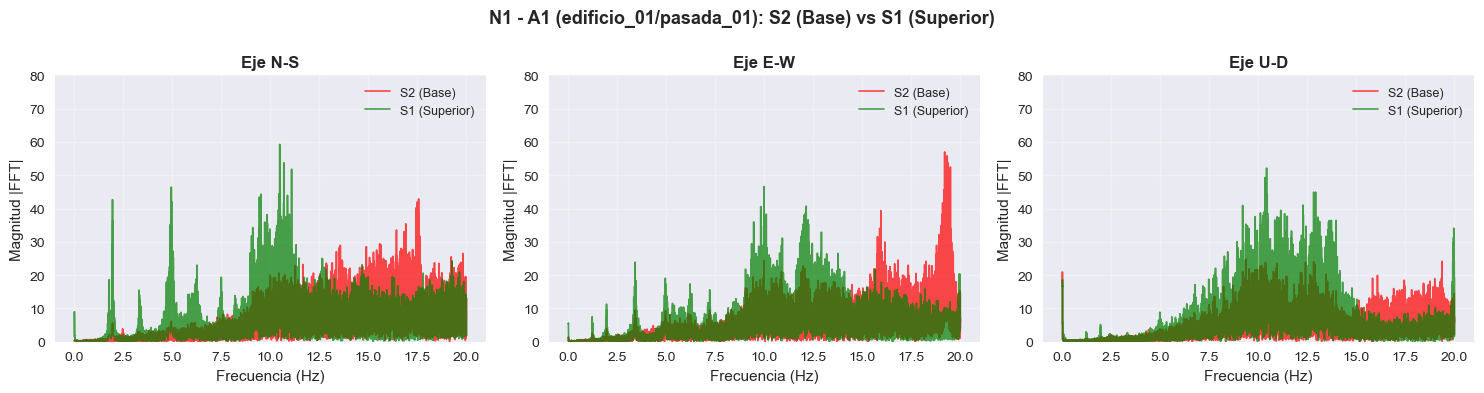

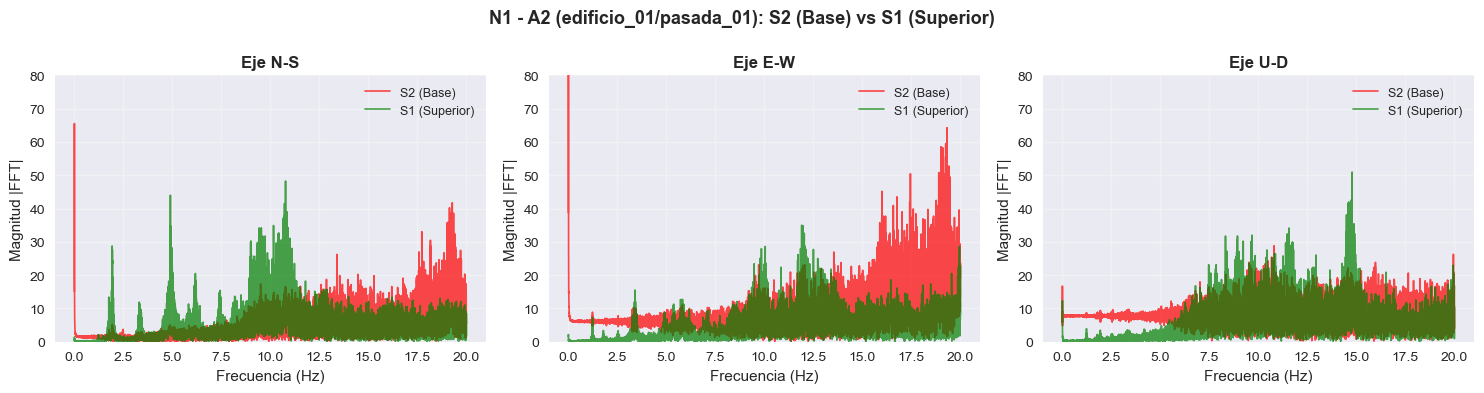

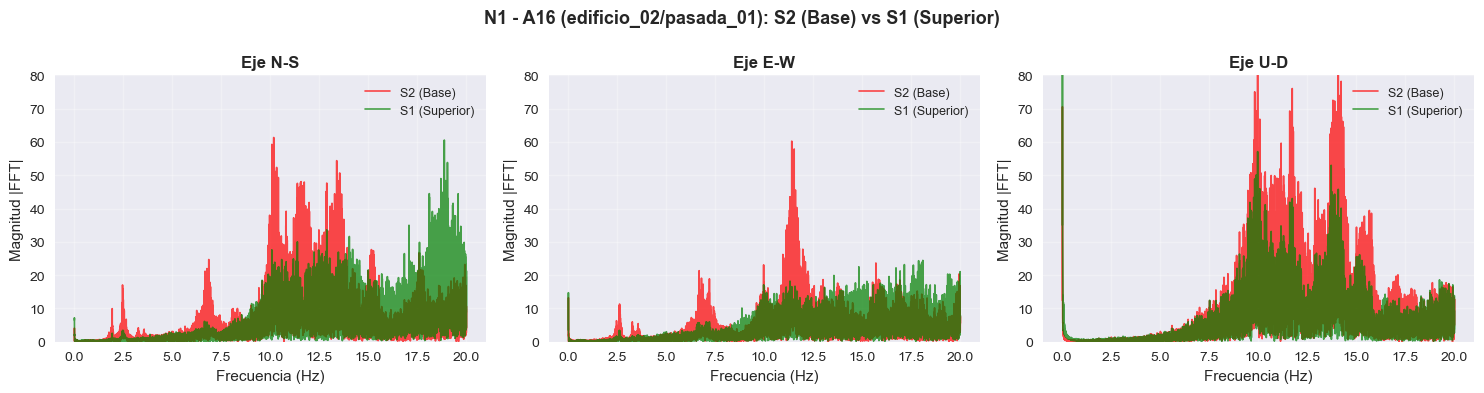

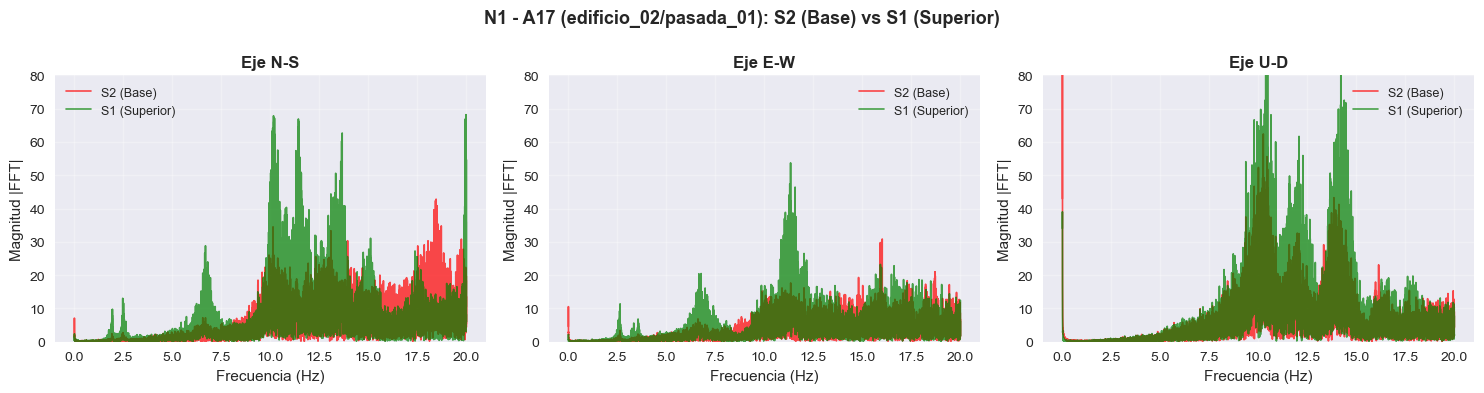

In [40]:
# Visualizar ejemplos de N1 de diferentes edificios
specimens_n1 = get_specimens(fft_data, [
    ('edificio_01', 'pasada_01', 'A1'),
    ('edificio_01', 'pasada_01', 'A2'),
    ('edificio_02', 'pasada_01', 'A16'),
    ('edificio_02', 'pasada_01', 'A17'),
    ('edificio_02', "pasada_02", 'A17')
])

print(f"Especímenes N1 encontrados: {len(specimens_n1)}")
for s in specimens_n1:
    print(f"  • {s['specimen_id']} - {s.get('edificio', 'N/A')}/{s.get('pasada', 'N/A')} - {s['nivel_dano']}")

print()
for specimen in specimens_n1:
    plot_fft_specimen(specimen)

### Espectros N2 (Daño moderado)

Especímenes N2 encontrados: 4
  • A8 - edificio_01/pasada_01 - N2
  • A9 - edificio_01/pasada_01 - N2
  • A2 - edificio_02/pasada_01 - N2
  • A23 - edificio_02/pasada_01 - N1



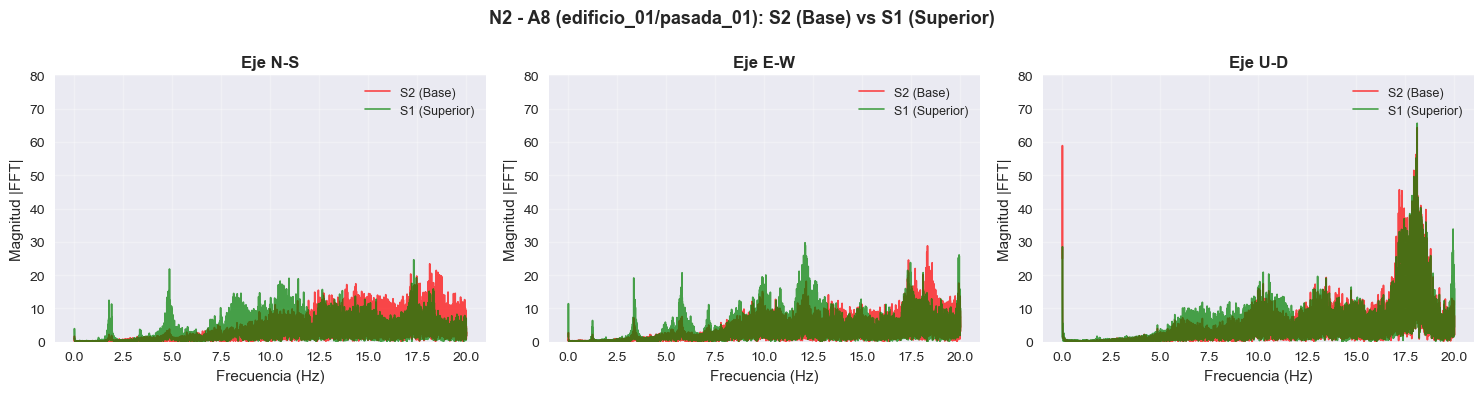

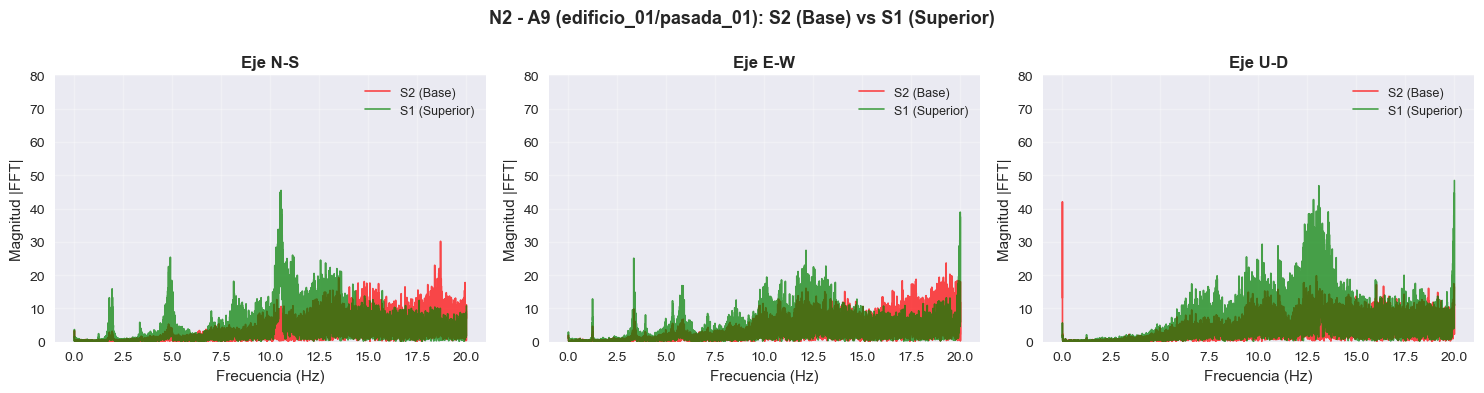

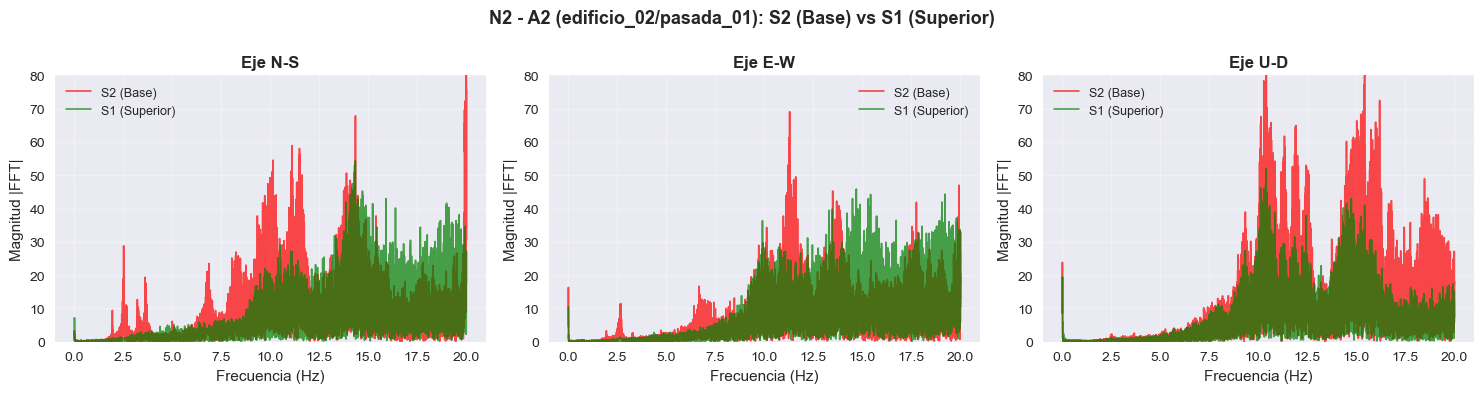

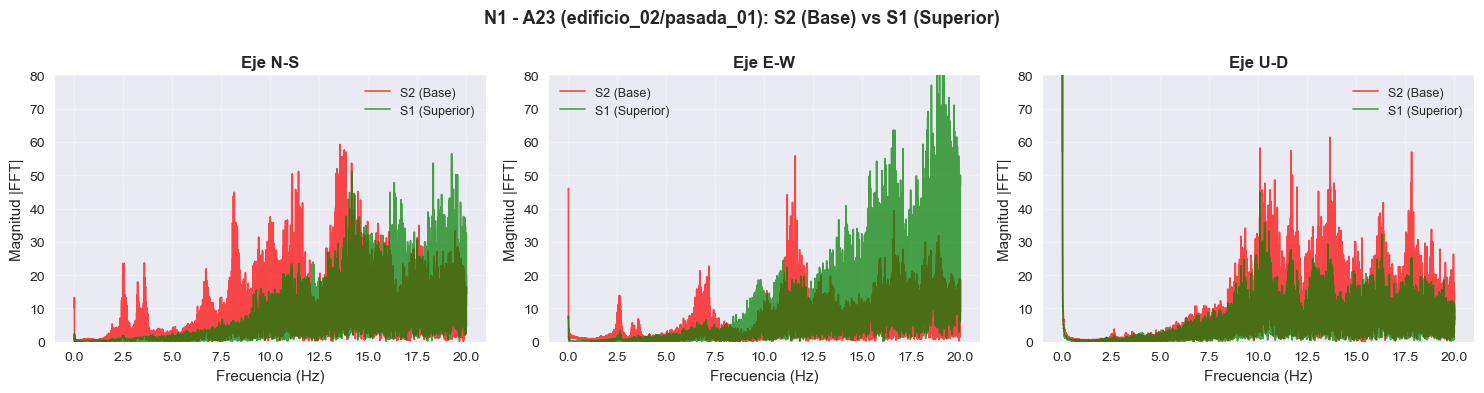

In [41]:
# Visualizar ejemplos de N2 de diferentes edificios
specimens_n2 = get_specimens(fft_data, [
    ('edificio_01', 'pasada_01', 'A8'),
    ('edificio_01', 'pasada_01', 'A9'),
    ('edificio_02', 'pasada_01', 'A2'),   # N2 en pasada_01
    ('edificio_02', 'pasada_01', 'A23'),
    ('edificio_02', 'pasada_02', 'A23')  # N2 en pasada_02
])

print(f"Especímenes N2 encontrados: {len(specimens_n2)}")
for s in specimens_n2:
    print(f"  • {s['specimen_id']} - {s.get('edificio', 'N/A')}/{s.get('pasada', 'N/A')} - {s['nivel_dano']}")

print()
for specimen in specimens_n2:
    plot_fft_specimen(specimen)

### Espectros N3 (Daño severo)

Especímenes N3 encontrados: ['A5', 'A6']



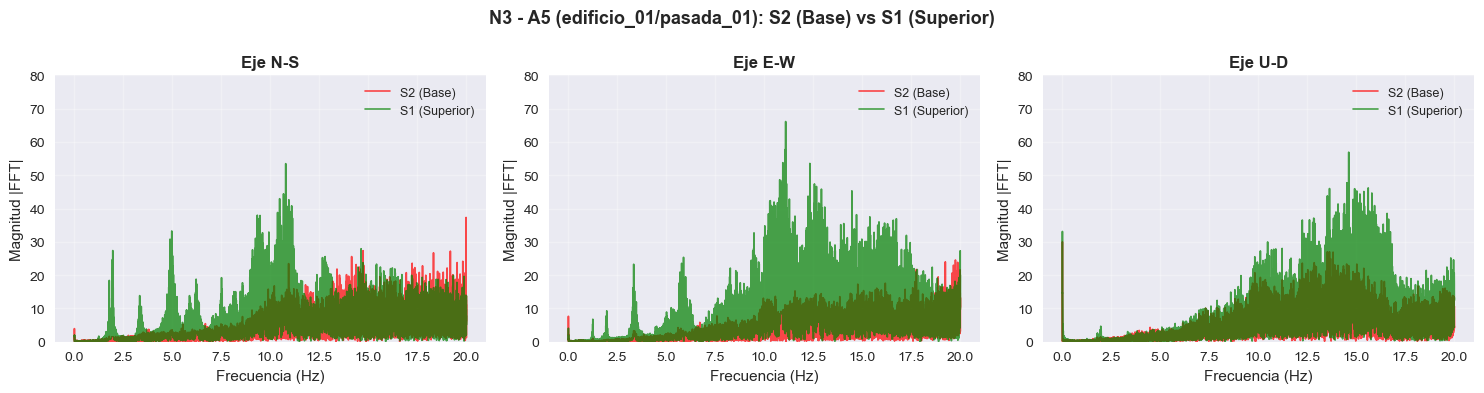

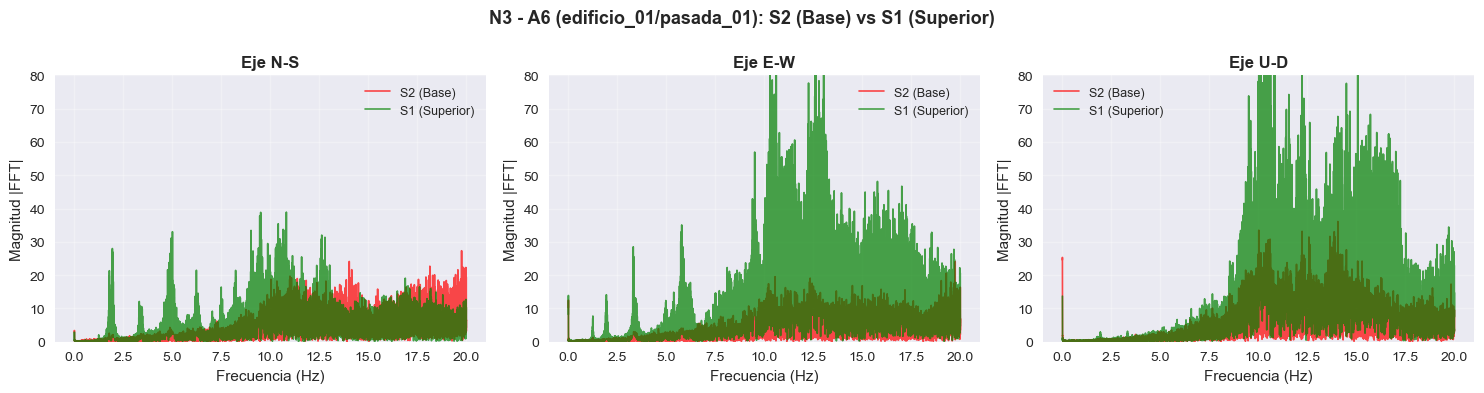

In [42]:
# Visualizar 3 ejemplos de N3
specimens_n3 = get_specimens_by_damage(fft_data, 'N3', n=3)
print(f"Especímenes N3 encontrados: {[s['specimen_id'] for s in specimens_n3]}\n")

for specimen in specimens_n3:
    plot_fft_specimen(specimen)

## 4. Visualización con Función de Transferencia y Diferencia Espectral

Analizamos la **relación entre S1 y S2**:
- **Ratio H(f) = |S1|/|S2|**: Función de transferencia
- **Diferencia Δ(f) = |S1| - |S2|**: Diferencia espectral

In [43]:
def plot_transfer_function(pair: dict, freq_max: float = 20.0, log_scale: bool = True, figsize: tuple = (15, 4)):
    """
    Plotea la Función de Transferencia H(f) = |S1(f)| / |S2(f)| para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        log_scale: Si True, usa escala logarítmica en eje Y
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - Espécimen {specimen_id}: Función de Transferencia H(f) = |S1|/|S2|', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        # Evitar división por cero
        epsilon = 1e-10
        H_f = mag_s1 / (mag_s2 + epsilon)
        
        ax.plot(freqs[freq_mask], H_f[freq_mask], 
                color='purple', alpha=0.8, linewidth=0.8)
        
        # Línea de referencia H(f) = 1
        ax.axhline(y=1, color='yellow', linestyle='--', linewidth=2, label='H(f)=1')
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('H(f) = |S1|/|S2|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        
        if log_scale:
            ax.set_yscale('log')
            ax.set_ylim(0.01, 100)  # Rango logarítmico
        else:
            ax.set_ylim(0, 10)
            
        ax.legend(fontsize=9, loc='upper right')
        ax.grid(True, alpha=0.3, which='both')
    
    plt.tight_layout()
    plt.show()


def plot_spectral_difference(pair: dict, freq_max: float = 20.0, figsize: tuple = (15, 4)):
    """
    Plotea la Diferencia Espectral Δ(f) = |S1(f)| - |S2(f)| para un espécimen.
    
    Args:
        pair: Diccionario con datos FFT del espécimen
        freq_max: Frecuencia máxima a mostrar (Hz)
        figsize: Tamaño de la figura
    """
    specimen_id = pair['specimen_id']
    nivel = pair['nivel_dano']
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(f'{nivel} - Espécimen {specimen_id}: Diferencia Espectral Δ(f) = |S1| - |S2|', 
                 fontsize=13, fontweight='bold')
    
    axis_names = ['N-S', 'E-W', 'U-D']
    freqs = pair['fft_S2']['freqs']
    freq_mask = freqs <= freq_max
    
    for idx, axis_name in enumerate(axis_names):
        ax = axes[idx]
        mag_s2 = pair['fft_S2']['magnitudes'][:, idx]
        mag_s1 = pair['fft_S1']['magnitudes'][:, idx]
        
        delta_f = mag_s1 - mag_s2
        
        # Plot con colores según signo
        ax.fill_between(freqs[freq_mask], 0, delta_f[freq_mask], 
                        where=(delta_f[freq_mask] >= 0),
                        color='red', alpha=0.5, label='S1 > S2 (amplificación)')
        ax.fill_between(freqs[freq_mask], 0, delta_f[freq_mask], 
                        where=(delta_f[freq_mask] < 0),
                        color='green', alpha=0.5, label='S1 < S2 (atenuación)')
        
        ax.axhline(y=0, color='black', linestyle='-', linewidth=1)
        
        ax.set_xlabel('Frecuencia (Hz)')
        ax.set_ylabel('Δ(f) = |S1| - |S2|')
        ax.set_title(f'Eje {axis_name}', fontweight='bold')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()


print("Funciones de análisis relacional definidas")

Funciones de análisis relacional definidas


### Función de Transferencia H(f)

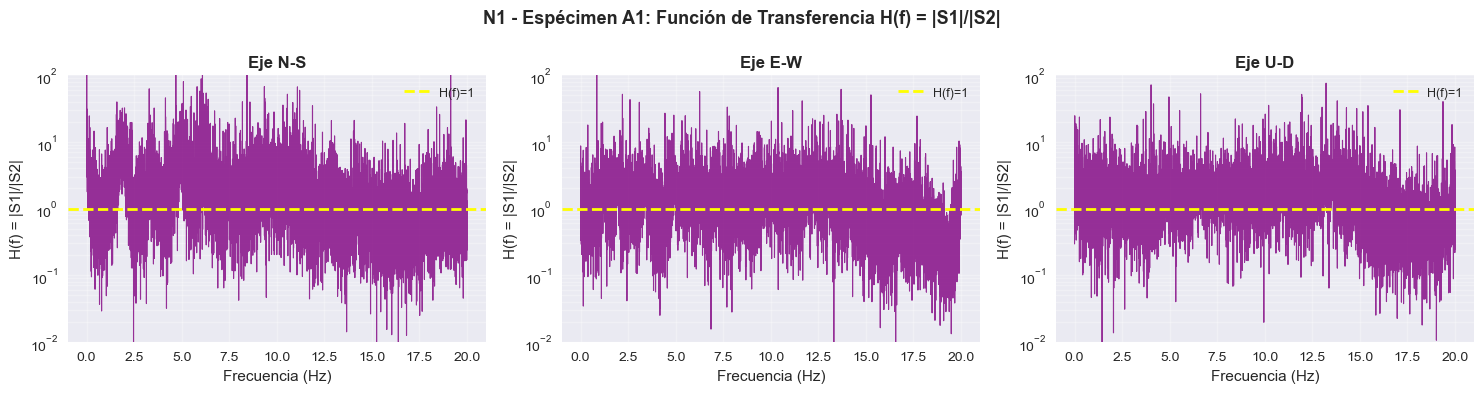

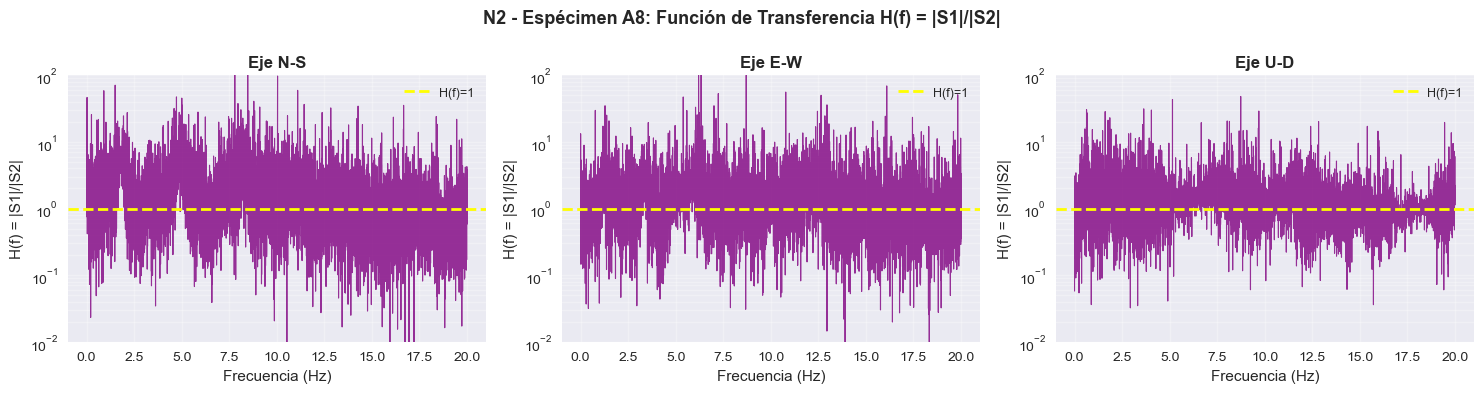

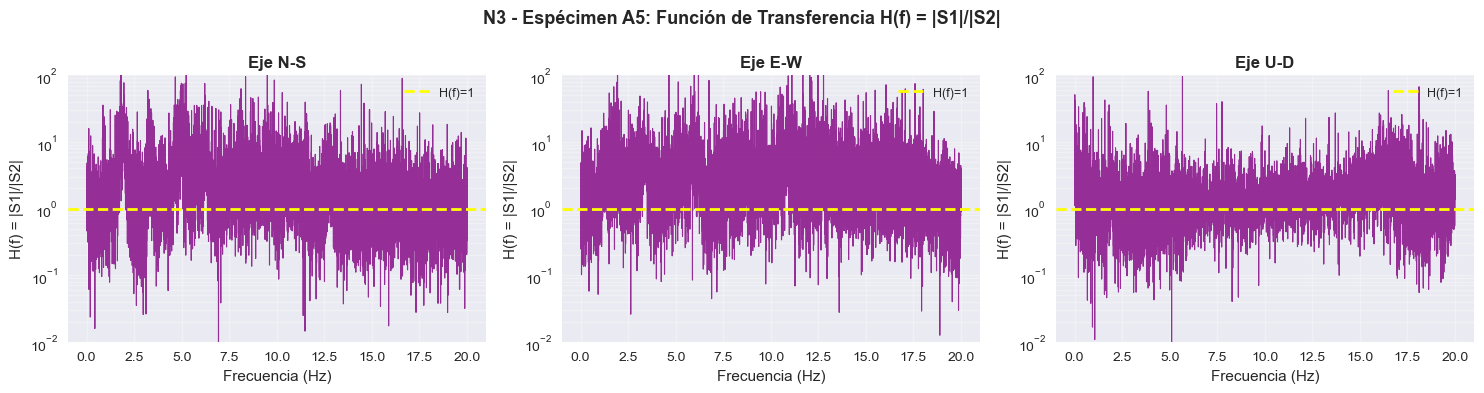

In [44]:
# H(f) para un espécimen de cada nivel
for nivel in ['N1', 'N2', 'N3']:
    specimens = get_specimens_by_damage(fft_data, nivel, n=1)
    if specimens:
        plot_transfer_function(specimens[0])

### Diferencia Espectral Δ(f)

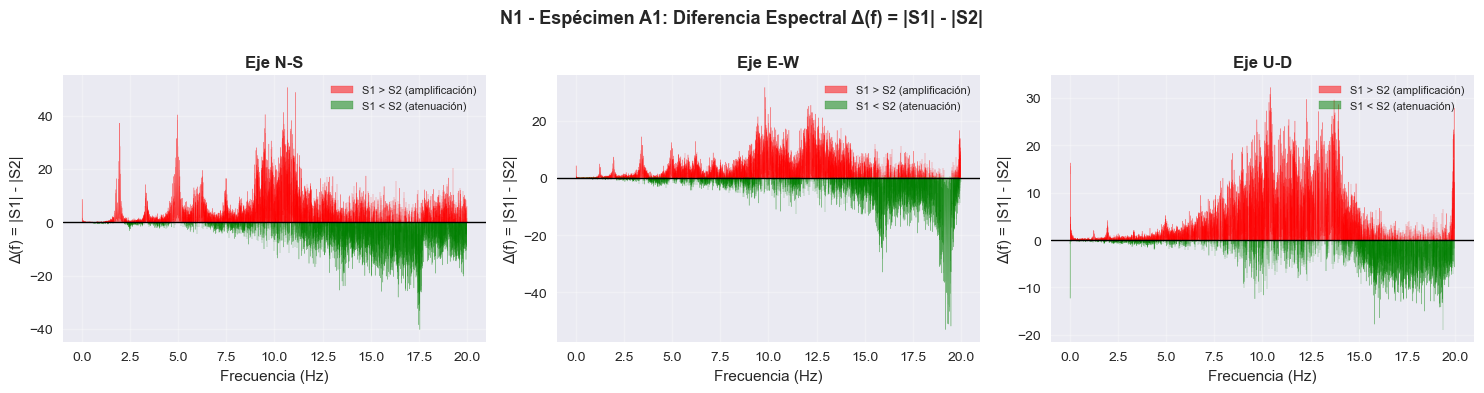

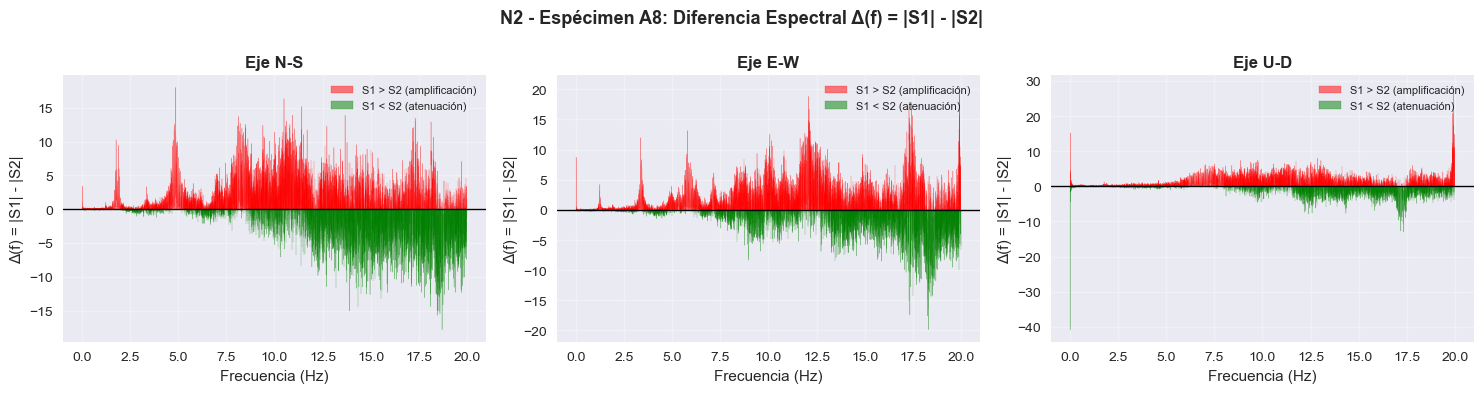

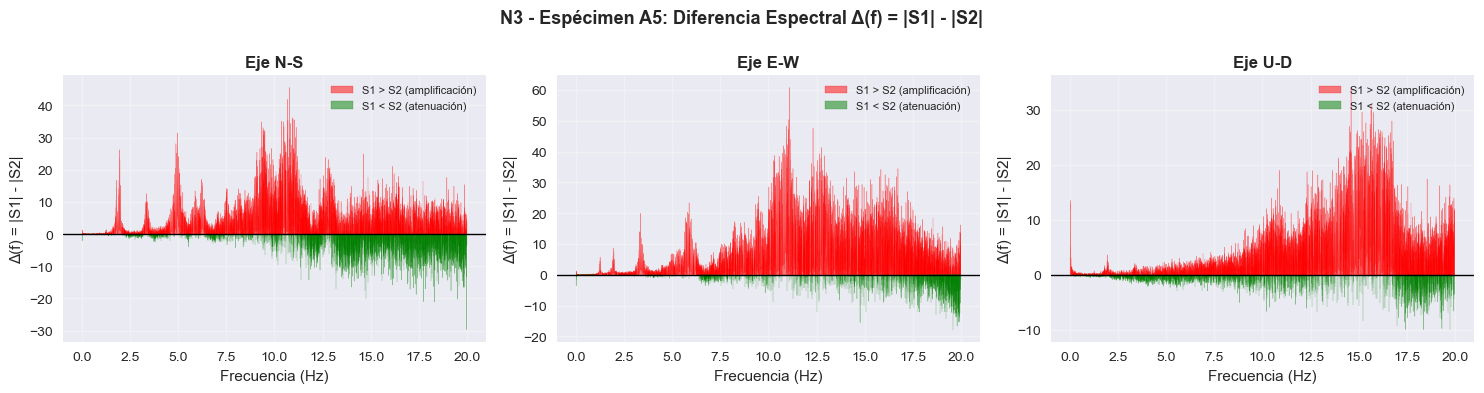

In [45]:
# Δ(f) para un espécimen de cada nivel
for nivel in ['N1', 'N2', 'N3']:
    specimens = get_specimens_by_damage(fft_data, nivel, n=1)
    if specimens:
        plot_spectral_difference(specimens[0])

## 5. Análisis de Clustering

Extraemos características espectrales y aplicamos K-Means para identificar agrupaciones naturales.

In [46]:
# Importar función de extracción de features
from clustering_utils import extract_simple_spectral_features

# Extraer características espectrales
# include_transfer_features=True agrega H(f) y Δ(f) → 36 features en lugar de 18
features_matrix, features_df, feature_names = extract_simple_spectral_features(
    fft_data=fft_data,
    freq_range=(0, 20),
    include_transfer_features=True  # Cambiar a False para usar solo features base
)

print(f"\n📊 Matriz de features lista para clustering:")
print(f"   Shape: {features_matrix.shape}")
print(f"   {features_matrix.shape[0]} especímenes × {features_matrix.shape[1]} características")

🔄 Extrayendo características espectrales...
   Rango de frecuencias: 0 - 20 Hz
   Include transfer features: True
   ✓ A1 (N1): 36 features extraídas
   ✓ A2 (N1): 36 features extraídas
   ✓ A3 (N1): 36 features extraídas
   ✓ A4 (N1): 36 features extraídas
   ✓ A5 (N3): 36 features extraídas
   ✓ A6 (N3): 36 features extraídas
   ✓ A7 (N1): 36 features extraídas
   ✓ A8 (N2): 36 features extraídas
   ✓ A9 (N2): 36 features extraídas
   ✓ A10 (N2): 36 features extraídas
   ✓ A11 (N2): 36 features extraídas
   ✓ A12 (N1): 36 features extraídas
   ✓ A13 (N1): 36 features extraídas
   ✓ A14 (N1): 36 features extraídas
   ✓ A1 (N1): 36 features extraídas
   ✓ A2 (N2): 36 features extraídas
   ✓ A3 (N1): 36 features extraídas
   ✓ A4 (N1): 36 features extraídas
   ✓ A5 (N1): 36 features extraídas
   ✓ A6 (N1): 36 features extraídas
   ✓ A7 (N1): 36 features extraídas
   ✓ A8 (N1): 36 features extraídas
   ✓ A9 (N1): 36 features extraídas
   ✓ A10 (N1): 36 features extraídas
   ✓ A11 (N1): 3

In [47]:
# Inspeccionar el DataFrame de features
print("📋 PRIMERAS 5 FILAS DEL DATAFRAME DE FEATURES:")
print(features_df.head().to_string())

print("\n📊 ESTADÍSTICAS DESCRIPTIVAS:")
print(features_df[feature_names].describe())

📋 PRIMERAS 5 FILAS DEL DATAFRAME DE FEATURES:
  tipo nivel_dano specimen_id  freq_dom_S2_NS  freq_dom_S2_EW  freq_dom_S2_UD  freq_dom_S1_NS  freq_dom_S1_EW  freq_dom_S1_UD  mag_peak_S2_NS  mag_peak_S2_EW  mag_peak_S2_UD  mag_peak_S1_NS  mag_peak_S1_EW  mag_peak_S1_UD  energy_S2_NS  energy_S2_EW  energy_S2_UD  energy_S1_NS  energy_S1_EW  energy_S1_UD  ratio_mean_NS  ratio_std_NS  ratio_max_NS  ratio_mean_EW  ratio_std_EW  ratio_max_EW  ratio_mean_UD  ratio_std_UD  ratio_max_UD  delta_mean_NS  delta_std_NS  delta_energy_NS  delta_mean_EW  delta_std_EW  delta_energy_EW  delta_mean_UD  delta_std_UD  delta_energy_UD
0    B         N1          A1       17.561667       19.196667        9.358333       42.889428       56.997480       24.829404       12.922365       12.783678        7.147575       10.476667        9.981667       10.418333     59.261876     46.586227     52.134369     15.424222     11.921319     17.036877       2.289350      4.611118    153.296726       1.631867      2.574768    

### Características Extraídas

Cada señal (S2 y S1) tiene **3 ejes de aceleración**: N-S, E-W, U-D.

#### Features Base (18 total)
Por cada sensor (S2, S1) y eje se extraen:

| Feature | Descripción |
|---------|-------------|
| `freq_dom` | Frecuencia del pico máximo |
| `mag_peak` | Magnitud del pico máximo |
| `energy` | Energía total (0-20 Hz) |

#### Features de Transferencia (18 adicionales)
Cuando `include_transfer_features=True`, se agregan features de la **relación S1/S2**:

| Feature | Fórmula | Descripción |
|---------|---------|-------------|
| `ratio_mean` | mean(S1/S2) | Media de la función de transferencia |
| `ratio_std` | std(S1/S2) | Variabilidad de la transferencia |
| `ratio_max` | max(S1/S2) | Pico máximo de amplificación |
| `delta_mean` | mean(S1-S2) | Media de la diferencia espectral |
| `delta_std` | std(S1-S2) | Variabilidad de la diferencia |
| `delta_energy` | sum(\|S1-S2\|) | Energía de la diferencia |

**Total:** 18 base + 18 transferencia = **36 features** (con `include_transfer_features=True`)

### Normalización de Features

Antes de aplicar clustering, necesitamos **normalizar** las características porque tienen escalas muy diferentes:
- Frecuencias: 0-20 Hz
- Magnitudes: pueden variar en varios órdenes de magnitud
- Energía: valores muy grandes

Usaremos **StandardScaler** (z-score normalization) para que todas las features tengan media=0 y std=1.

In [48]:
from sklearn.preprocessing import StandardScaler

# Normalizar features
scaler = StandardScaler()
features_normalized = scaler.fit_transform(features_matrix)

print("📊 Features normalizadas:")
print(f"   Shape: {features_normalized.shape}")
print(f"   Media por feature: {features_normalized.mean(axis=0).mean():.6f} (≈0)")
print(f"   Std por feature: {features_normalized.std(axis=0).mean():.6f} (≈1)")
print(f"\n✅ Normalización completada")

📊 Features normalizadas:
   Shape: (51, 36)
   Media por feature: -0.000000 (≈0)
   Std por feature: 1.000000 (≈1)

✅ Normalización completada


### Método del Codo

Técnica para determinar el número óptimo de clusters (k):
- Ejecuta K-Means para diferentes valores de k
- Calcula la inercia (WCSS) para cada k
- Busca el "codo": punto donde la inercia deja de disminuir significativamente

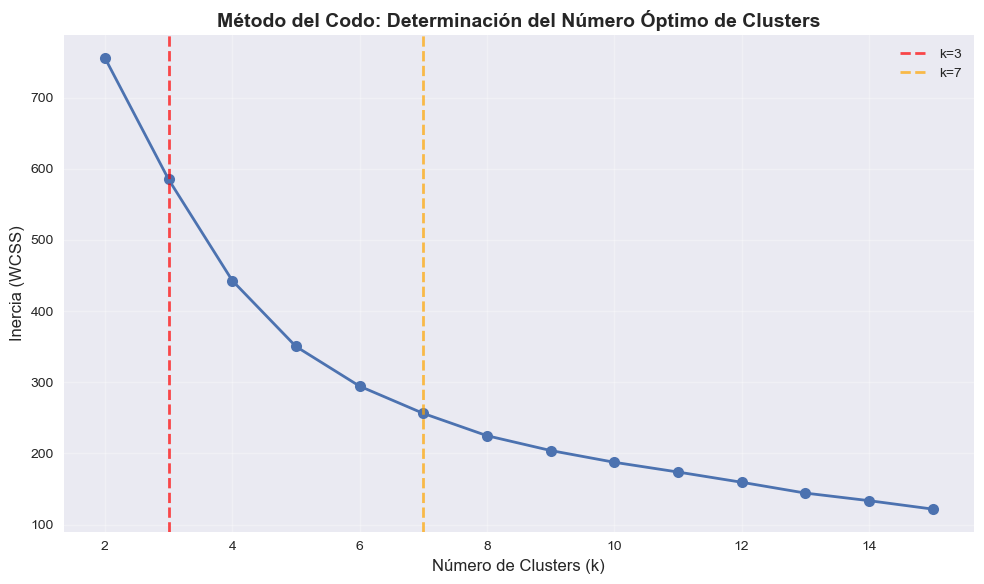

✅ Método del codo completado

📊 Interpretación:
   • Busca el 'codo' donde la inercia deja de disminuir significativamente
   • El codo indica el número óptimo de clusters
   • Inercia para k=3: 585.03
   • Inercia para k=7: 256.24


In [49]:
from sklearn.cluster import KMeans

# Calcular inercia para diferentes valores de k
k_range = range(2, 16)
inertias = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_normalized)
    inertias.append(kmeans.inertia_)

# Graficar método del codo
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertias, marker='o', linewidth=2, markersize=8)
plt.axvline(x=3, color='red', linestyle='--', linewidth=2, alpha=0.7, label='k=3')
plt.axvline(x=7, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='k=7')
plt.xlabel('Número de Clusters (k)', fontsize=12)
plt.ylabel('Inercia (WCSS)', fontsize=12)
plt.title('Método del Codo: Determinación del Número Óptimo de Clusters', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print("✅ Método del codo completado")
print("\n📊 Interpretación:")
print("   • Busca el 'codo' donde la inercia deja de disminuir significativamente")
print("   • El codo indica el número óptimo de clusters")
print(f"   • Inercia para k=3: {inertias[1]:.2f}")
print(f"   • Inercia para k=7: {inertias[5]:.2f}")

### Reducción de Dimensionalidad (PCA)

Aplicamos PCA para visualizar los datapoints en 2D. Primero evaluamos cuánta varianza captura cada componente.

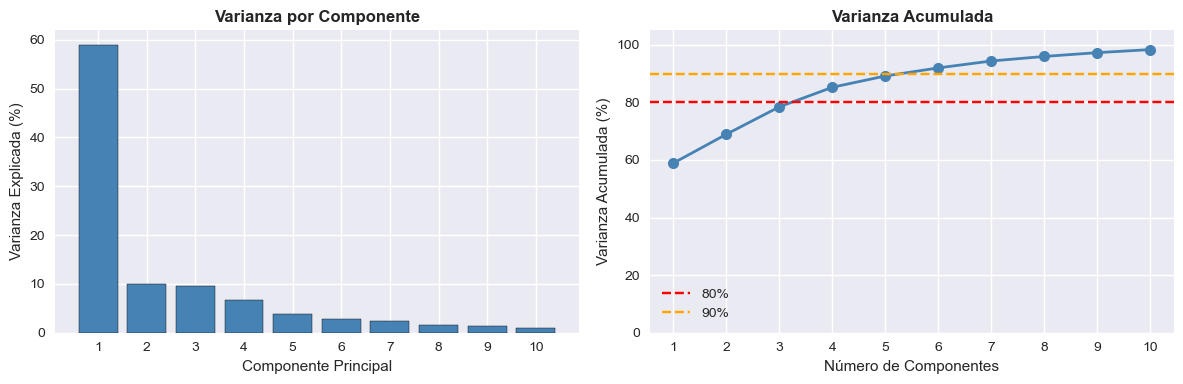

Varianza explicada:
  PC1:      58.9%
  PC1+PC2:  69.0%  (2D)
  PC1-3:    78.5%  (3D)

→ 3D agrega solo 9.5% más de varianza


In [50]:
# Scree Plot: Varianza explicada por componente
from sklearn.decomposition import PCA

pca_full = PCA().fit(features_normalized)
var_explicada = pca_full.explained_variance_ratio_
var_acumulada = np.cumsum(var_explicada)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Varianza por componente
n_components = min(10, len(var_explicada))
axes[0].bar(range(1, n_components + 1), var_explicada[:n_components] * 100, 
            color='steelblue', edgecolor='black')
axes[0].set_xlabel('Componente Principal')
axes[0].set_ylabel('Varianza Explicada (%)')
axes[0].set_title('Varianza por Componente', fontweight='bold')
axes[0].set_xticks(range(1, n_components + 1))

# Plot 2: Varianza acumulada
axes[1].plot(range(1, n_components + 1), var_acumulada[:n_components] * 100, 
             'o-', color='steelblue', linewidth=2, markersize=8)
axes[1].axhline(y=80, color='red', linestyle='--', label='80%')
axes[1].axhline(y=90, color='orange', linestyle='--', label='90%')
axes[1].set_xlabel('Número de Componentes')
axes[1].set_ylabel('Varianza Acumulada (%)')
axes[1].set_title('Varianza Acumulada', fontweight='bold')
axes[1].set_xticks(range(1, n_components + 1))
axes[1].legend()
axes[1].set_ylim(0, 105)

plt.tight_layout()
plt.show()

# Resumen
print(f"Varianza explicada:")
print(f"  PC1:     {var_explicada[0]*100:>5.1f}%")
print(f"  PC1+PC2: {var_acumulada[1]*100:>5.1f}%  (2D)")
print(f"  PC1-3:   {var_acumulada[2]*100:>5.1f}%  (3D)")
print(f"\n→ 3D agrega solo {(var_acumulada[2]-var_acumulada[1])*100:.1f}% más de varianza")

**Interpretación:**
- La varianza está muy distribuida: se necesitan ~7 componentes para 80%
- PC3 solo agrega ~11% adicional sobre PC1+PC2
- La visualización 2D captura ~43% de la varianza total
- No se justifica usar 3D por la complejidad visual vs. ganancia marginal

In [51]:
from sklearn.decomposition import PCA

# Aplicar PCA para reducir a 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_normalized)

print("📊 PCA aplicado:")
print(f"   Shape original: {features_normalized.shape}")
print(f"   Shape reducida: {features_pca.shape}")
print(f"\n📈 Varianza explicada por componente:")
print(f"   PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"   PC2: {pca.explained_variance_ratio_[1]:.2%}")
print(f"   Total: {pca.explained_variance_ratio_.sum():.2%}")
print(f"\n✅ Reducción de dimensionalidad completada")

📊 PCA aplicado:
   Shape original: (51, 36)
   Shape reducida: (51, 2)

📈 Varianza explicada por componente:
   PC1: 58.94%
   PC2: 10.01%
   Total: 68.95%

✅ Reducción de dimensionalidad completada


### Visualización de Datos Reales

Distribución de especímenes en espacio PCA, coloreados por etiqueta real (N1, N2, N3).

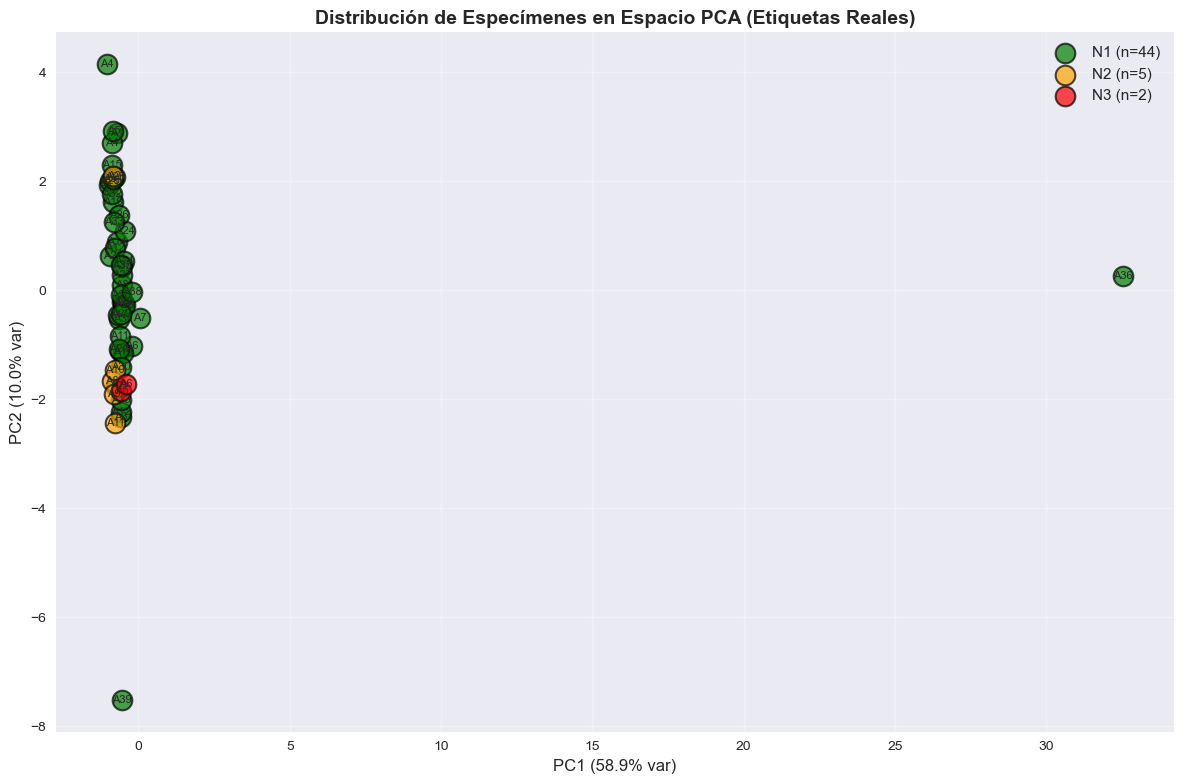

✅ Visualización completada

📊 OBSERVACIONES:
   • ¿Se agrupan naturalmente los especímenes del mismo nivel de daño?
   • ¿Hay solapamiento entre N1, N2, N3?
   • ¿Se observan outliers?


In [52]:
# Crear visualización de los datos reales en espacio PCA
fig, ax = plt.subplots(figsize=(12, 8))

# Colores por nivel de daño (incluyendo Sin_etiqueta)
colors = {'N1': 'green', 'N2': 'orange', 'N3': 'red', 'Sin_etiqueta': 'gray'}
labels_real = features_df['nivel_dano'].values
specimen_ids = features_df['specimen_id'].values

for nivel in ['N1', 'N2', 'N3', 'Sin_etiqueta']:
    mask = labels_real == nivel
    if mask.sum() == 0:  # Skip si no hay especímenes de este tipo
        continue
    
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=colors[nivel],
        label=f'{nivel} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs de especímenes
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=8,
            ha='center',
            va='center'
        )

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Distribución de Especímenes en Espacio PCA (Etiquetas Reales)', fontsize=14, fontweight='bold')
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✅ Visualización completada")
print("\n📊 OBSERVACIONES:")
print("   • ¿Se agrupan naturalmente los especímenes del mismo nivel de daño?")
print("   • ¿Hay solapamiento entre N1, N2, N3?")
print("   • ¿Se observan outliers?")

### Aplicación de K-Means (k=3)

Aplicamos K-Means con k=3 clusters para evaluar si descubre grupos que coincidan con N1, N2, N3.

In [53]:
from sklearn.cluster import KMeans

# Aplicar K-Means con k=3
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(features_normalized)

# Agregar etiquetas de cluster al DataFrame
features_df['cluster'] = cluster_labels

print("📊 K-Means aplicado:")
print(f"   Número de clusters: 3")
print(f"   Inercia (within-cluster sum of squares): {kmeans.inertia_:.2f}")
print(f"\n📈 Distribución de especímenes por cluster:")
print(features_df['cluster'].value_counts().sort_index())

print(f"\n📋 Comparación Cluster vs Nivel de Daño Real:")
comparison = pd.crosstab(features_df['nivel_dano'], features_df['cluster'], 
                         rownames=['Nivel Daño'], colnames=['Cluster'])
print(comparison)

📊 K-Means aplicado:
   Número de clusters: 3
   Inercia (within-cluster sum of squares): 585.03

📈 Distribución de especímenes por cluster:
cluster
0    49
1     1
2     1
Name: count, dtype: int64

📋 Comparación Cluster vs Nivel de Daño Real:
Cluster      0  1  2
Nivel Daño          
N1          42  1  1
N2           5  0  0
N3           2  0  0


### Visualización de Clusters

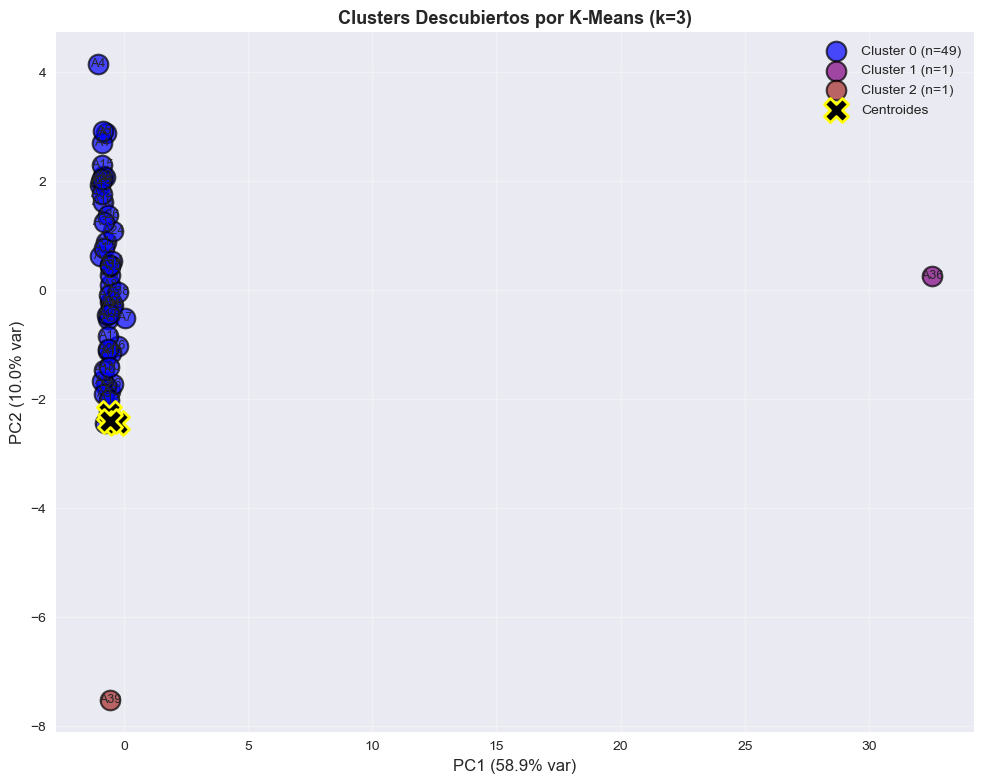

In [54]:
# Visualización: Clusters descubiertos por K-Means
fig, ax = plt.subplots(figsize=(10, 8))

cluster_colors = {0: 'blue', 1: 'purple', 2: 'brown'}

for cluster_id in range(3):
    mask = cluster_labels == cluster_id
    ax.scatter(
        features_pca[mask, 0],
        features_pca[mask, 1],
        c=cluster_colors[cluster_id],
        label=f'Cluster {cluster_id} (n={mask.sum()})',
        s=200,
        alpha=0.7,
        edgecolors='black',
        linewidths=1.5
    )
    
    # Anotar IDs
    for i, specimen_id in enumerate(specimen_ids[mask]):
        ax.annotate(
            specimen_id,
            (features_pca[mask, 0][i], features_pca[mask, 1][i]),
            fontsize=9,
            ha='center',
            va='center'
        )

# Plot centroides
centroids_pca = pca.transform(scaler.transform(kmeans.cluster_centers_))
ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], 
           c='black', marker='X', s=300, 
           edgecolors='yellow', linewidths=2,
           label='Centroides', zorder=10)

ax.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} var)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} var)', fontsize=12)
ax.set_title('Clusters Descubiertos por K-Means (k=3)', fontsize=13, fontweight='bold')
ax.legend(fontsize=10, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Métricas de Evaluación

In [55]:
from clustering_utils import evaluate_clustering

metrics = evaluate_clustering(
    features=features_normalized,
    cluster_labels=cluster_labels,
    labels_real=labels_real,
    kmeans_model=kmeans,
    experiment_name="FFT + K-Means (k=3) con transfer features"
)

📊 MÉTRICAS: FFT + K-Means (k=3) con transfer features

🔹 Intrínsecas:
   Inertia:               585.03
   Silhouette:            0.6401  [-1, 1] ↑
   Davies-Bouldin:        0.1926  [0, ∞) ↓
   Calinski-Harabasz:      51.32  [0, ∞) ↑

🔹 Extrínsecas (51/51 con etiqueta):
   ARI:                  -0.0582  [-1, 1] ↑
   NMI:                   0.0175  [0, 1] ↑
   Homogeneity:           0.0123  [0, 1] ↑
   Completeness:          0.0307  [0, 1] ↑
   V-Measure:             0.0175  [0, 1] ↑


### Registro del Experimento

Registramos métricas y metadata en CSV para análisis comparativo.

In [56]:
# Registrar experimento en CSV
logger.log_experiment(
    experiment_id="fft_kmeans_k3_transfer",
    notebook_name="2_clustering_fft_kmeans",
    algorithm="kmeans",
    frequency_transform="fft",
    n_clusters=3,
    pca_dims=2,
    feature_set="spectral_with_transfer",
    
    # Métricas intrínsecas (desde dict metrics)
    inertia=metrics.get('inertia'),
    silhouette_score=metrics.get('silhouette'),
    davies_bouldin_index=metrics.get('davies_bouldin'),
    calinski_harabasz_score=metrics.get('calinski'),
    
    # Métricas extrínsecas
    adjusted_rand_index=metrics.get('ari'),
    normalized_mutual_info=metrics.get('nmi'),
    homogeneity=metrics.get('homogeneity'),
    completeness=metrics.get('completeness'),
    v_measure=metrics.get('v_measure'),
    
    # Metadata adicional
    n_samples=len(features_normalized),
    n_features=features_normalized.shape[1],
    notes="FFT + features espectrales + transfer features (ratio, delta) + K-Means k=3"
)

print(f"\n✅ Experimento registrado en: {RESULTS_FILE}")

🔄 Experimento actualizado: 2_clustering_fft_kmeans | kmeans | fft (ID: fft_kmeans_k3_transfer)

✅ Experimento registrado en: clustering_experiments.csv
